More about objective for regression: https://xgboost.readthedocs.io/en/stable/parameter.html

In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from collections import Counter
from time import localtime, strftime
import math
from helper import ( prepare_data, train_test_shuffle_split, train_test_seq_split, print_folds_stats )

from xgboost import XGBRegressor

from matplotlib import pyplot as plt
plt.style.use('ggplot')     # 'fivethirtyeight'
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/andrew.nedilko/opt/anaconda3/envs/iq/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Part 1. Linear Implementation

In [2]:
events = { 'tex2step' : {
                            'file': 'data/2step_20221229.csv',
                            'features': ['Num1', 'Num2', 'Num3', 'Num4',]
                         }
        }
event = 'tex2step'

In [3]:
file     = events[ event ]['file']
features = events[ event ]['features']

df = pd.read_csv( file, encoding='utf-8' )
print('Shape of data:', df.shape, '\n')

Shape of data: (2256, 9) 



In [4]:
n_steps      = 1
random_state = 34
overlap      = True
flatten      = True
y_pos        = 0

( X,
  y, )  = prepare_data(  df,
                         features,
                         n_steps,
                         overlap=overlap,
                         flatten=flatten,
                         y_pos=y_pos, )
print('X and y shape:', X.shape, y.shape)
'''
max_value = max(y)
print(f'Replacing y={max_value} with 0 for use with XGBoost')
y[y==max_value] = 0
max_value = max(y)
print(f'Max value after replacement: {max_value}')
'''

X and y shape: (2255, 4) (2255,)


"\nmax_value = max(y)\nprint(f'Replacing y={max_value} with 0 for use with XGBoost')\ny[y==max_value] = 0\nmax_value = max(y)\nprint(f'Max value after replacement: {max_value}')\n"

In [5]:
X, y

(array([[ 9, 10, 22, 13],
        [30, 34, 23,  4],
        [ 3, 29, 18, 33],
        ...,
        [11, 26, 14, 33],
        [19,  4, 33, 26],
        [ 2, 26, 20,  6]]),
 array([30,  3, 23, ..., 19,  2,  8]))

In [6]:
# COUNT LABELS
c = Counter(y)
c.most_common()

[(25, 86),
 (30, 79),
 (4, 75),
 (8, 75),
 (21, 73),
 (22, 73),
 (12, 71),
 (6, 70),
 (9, 70),
 (17, 69),
 (7, 68),
 (34, 68),
 (15, 67),
 (1, 67),
 (10, 67),
 (26, 66),
 (31, 65),
 (35, 64),
 (32, 62),
 (11, 62),
 (2, 62),
 (19, 62),
 (3, 61),
 (20, 61),
 (33, 60),
 (18, 60),
 (13, 60),
 (23, 59),
 (5, 59),
 (29, 58),
 (16, 57),
 (27, 57),
 (24, 49),
 (28, 47),
 (14, 46)]

## Visualize y

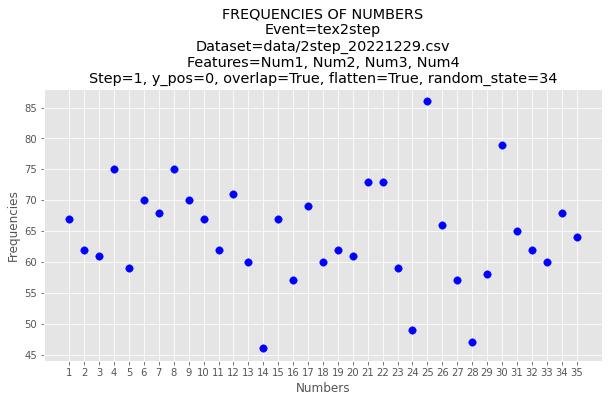

In [7]:
# PLOT LABEL FREQUENCIES
x_ = list(c.keys())
y_ = list(c.values())
title = f"FREQUENCIES OF NUMBERS\nEvent={event}\nDataset={file}\nFeatures={', '.join(features)}\n" +\
        f'Step={n_steps}, y_pos={y_pos}, overlap={overlap}, flatten={flatten}, random_state={random_state}'

plt.figure(figsize=(10, 5))
plt.scatter(x_, y_, c='blue', s=55)
plt.xticks(x_)
plt.title(title)
plt.xlabel('Numbers')
plt.ylabel('Frequencies')
#plt.tight_layout()
plt.show()

__Outliers: 14, 24, 25, 28, 30__

/Users/andrew.nedilko/opt/anaconda3/envs/iq/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


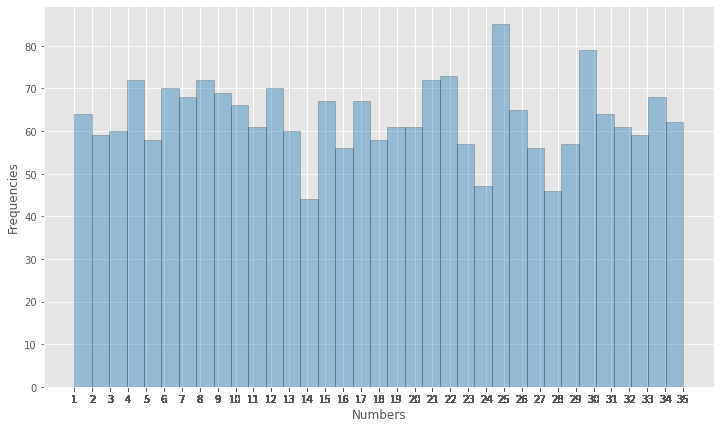

In [63]:
plt.figure(figsize=(12, 7))
sns.distplot( y, hist=True, kde=False,
              bins=35, color='tab:blue',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth':4}
            )
plt.xticks(y)
plt.xlabel('Numbers')
plt.ylabel('Frequencies')
plt.show()

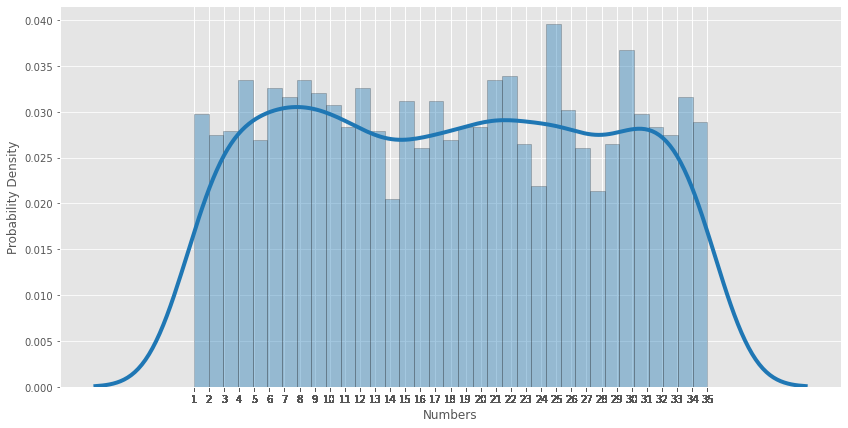

In [62]:
plt.figure(figsize=(14, 7))
sns.distplot( y, hist=True, kde=True,
              bins=35, color='tab:blue',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth':4}
            )
plt.xticks(y)
plt.xlabel('Numbers')
plt.ylabel('Probability Density')
plt.show()

In [8]:
test_size=0.2

# stratified implemented only if shuffle=True
X_sh, y_sh = deepcopy(X), deepcopy(y)
X_train_sh, X_test_sh, y_train_sh, y_test_sh = train_test_split( X_sh, y_sh,
                                                                 test_size=test_size,
                                                                 random_state=random_state,
                                                                 shuffle=True,
                                                                 #stratify=y,
                                                               )

# not stratified - time series
X_train, X_test, y_train, y_test = train_test_seq_split(X, y, test_size=test_size)

In [9]:
regr_params_xgb = {
    'n_estimators': 100,
    'max_depth': None,                                # default 6
    'learning_rate': 0.2,                             # eta, default 0.3
    'objective': 'reg:squarederror',                  # reg:squarederror, reg:squaredlogerror, reg:pseudohubererror, reg:tweedie, reg:gamma           
    'eval_metric': 'rmse',                            # 'rmse', 'rmsle', 'mae', 'mape', 'mphe' (huber), 'logloss',
                                                      # OR 'eval_metric': mean_absolute_error, import sklearn metric, then reg.fit(X, y, eval_set=[(X, y)])
    #'early_stopping_rounds': 5,                      # requires eval_set
    'max_leaves': 0,                                  # max # leaves; default 0 - no limit
    'grow_policy': 'depthwise',                       # default 'depthwise', 'lossguide'
    'process_type': 'default',                        # 'default', 'update' for boosting
    'num_parallel_tree': 1,                           # default 1, num parallel trees built in each iteration
    'base_score': 0.5,
    'booster': 'gbtree',                              # gbtree, dart, gblinear?
    'tree_method': 'auto',                            # auto, exact, approx, hist and gpu_hist
    'importance_type': 'weight',                      # default“gain”,“weight”,“cover”,“total_gain”,“total_cover”
    'gamma': 0.4,                                     # larger - more conservative, [0, inf], default 0
    'reg_alpha': 0.9,                                 # L1 reg., larger - more conservative, default 0 (0.1)
    'reg_lambda': 8,                                  # L2 rreg., larger - more conservative, default 1 (0.3)
    'sampling_method': 'uniform',                     # uniform, gradient_based
    'max_delta_step': 0,                              # 1-10 or 0 for no constraint
    'min_child_weight': 1,
    'subsample': 0.7,                                 # 0-1  (lower values prevent overfitting), default 1
    'colsample_bylevel': 0,                           # 0-1, default 1
    'colsample_bynode': 1,                            # optimized for higher recall, default 1
    'colsample_bytree': 1,                            # 0-1, default 1
    'seed': 5,
    'random_state': random_state,
    'n_jobs': -1,
    #'callbacks':,    # e.g. xgboost.callback.EarlyStopping
}

## Time Series Split (No Shuffling)

In [10]:
# FIT & TEST
regr = XGBRegressor( **regr_params_xgb )
regr.fit( X_train, y_train )
y_pred = regr.predict( X_test )

# PRINT RESULTS
print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
print(f'Event: {event}\nDataset: {file}\nTrain-test split: time series\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}\n')

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f'RMSE = {round(rmse, 4)}')
print(f'MAE  = {round(mae, 4)}')
print(f'R2   = {round(r2, 4)}')

2022-12-30 01:21:15
Event: tex2step
Dataset: data/2step_20221229.csv
Train-test split: time series
Steps: 1  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 11.4178
MAE  = 9.6969
R2   = -0.2484


In [243]:
for i, j in zip(y_test, y_pred):
    print(f'{i}:  {j}')

35:  20.337631225585938
33:  15.913426399230957
9:  19.58885383605957
1:  18.16238021850586
19:  18.260969161987305
4:  17.617769241333008
23:  13.98501205444336
25:  14.27348518371582
12:  17.451160430908203
18:  18.61576271057129
6:  19.997608184814453
31:  19.21049690246582
29:  22.209917068481445
10:  19.76985740661621
23:  14.537557601928711
6:  18.419174194335938
34:  21.164653778076172
24:  21.54300308227539
12:  20.12346076965332
1:  13.869784355163574
19:  22.466650009155273
1:  13.551835060119629
5:  19.08245277404785
14:  22.209369659423828
3:  22.438549041748047
5:  16.88370132446289
24:  18.944124221801758
18:  16.027589797973633
2:  13.150677680969238
12:  17.025846481323242
25:  14.360456466674805
21:  23.327329635620117
35:  14.463661193847656
17:  18.60590171813965
12:  18.51820945739746
31:  17.787076950073242
22:  16.53472900390625
4:  17.735729217529297
16:  15.30312728881836
17:  20.439340591430664
30:  11.789159774780273
19:  16.776885986328125
26:  19.64951515197

## Stratified Split (With Shuffling)

In [11]:
# FIT & TEST
regr_sh = XGBRegressor( **regr_params_xgb )
regr_sh.fit( X_train_sh, y_train_sh )
y_pred_sh = regr_sh.predict( X_test_sh )

# PRINT RESULTS
print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
print(f'Event: {event}\nDataset: {file}\nTrain-test split: stratified w/shuffling\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}\n')

rmse_sh = math.sqrt(mean_squared_error(y_test_sh, y_pred_sh))
mae_sh  = mean_absolute_error(y_test_sh, y_pred_sh)
r2_sh   = r2_score(y_test_sh, y_pred_sh)

print(f'RMSE = {round(rmse_sh, 4)}')
print(f'MAE  = {round(mae_sh, 4)}')
print(f'R2   = {round(r2_sh, 4)}')

2022-12-30 01:21:25
Event: tex2step
Dataset: data/2step_20221229.csv
Train-test split: stratified w/shuffling
Steps: 1  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 11.3654
MAE  = 9.7774
R2   = -0.1956


In [12]:
for i, j in zip(y_test_sh, y_pred_sh):
    print(f'{i}:  {j}')

32:  19.091472625732422
34:  16.385570526123047
25:  15.164641380310059
29:  13.246853828430176
34:  18.6776065826416
6:  20.891389846801758
1:  14.73335075378418
31:  18.9715633392334
1:  16.402280807495117
18:  16.345699310302734
18:  22.61959457397461
24:  19.981168746948242
21:  11.298429489135742
21:  13.31687068939209
10:  16.82210350036621
31:  15.54427433013916
8:  19.098478317260742
29:  14.37063217163086
23:  18.423622131347656
10:  12.468439102172852
35:  23.27314567565918
25:  9.845248222351074
4:  17.403371810913086
12:  13.583745002746582
2:  16.055917739868164
35:  16.28664779663086
28:  12.847975730895996
27:  19.627653121948242
33:  20.219200134277344
7:  12.691118240356445
19:  16.98001480102539
13:  20.64663314819336
5:  28.365699768066406
30:  19.60395622253418
25:  20.470260620117188
26:  20.159053802490234
16:  9.50401496887207
23:  15.91486930847168
26:  13.572760581970215
16:  11.911974906921387
33:  21.852880477905273
11:  8.390151977539062
21:  18.464933395385

In [ ]:
unknown_variable

# Part 2. Parameter Search Loop

In [228]:
random_state = 34
n_steps      = 12
overlap      = True
flatten      = True
y_pos        = 0

keys         = ['value', 'rmse', 'mae', 'r2', 'rmse_sh', 'mae_sh', 'r2_sh', ]
res          = []
value_name   = 'colsample_bytree'

for value in range(0, 101, 5):
        
    modified_value = value/100
        
    # PREPARE DATA
    ( X,
      y, )  = prepare_data(  df,
                             features,
                             n_steps,
                             overlap=overlap,
                             flatten=flatten,
                             y_pos=y_pos, )
    #print('X and y shape:', X.shape, y.shape)
    
    # TRAIN-TEST SPLIT
    test_size=0.2

    # stratified implemented only if shuffle=True
    X_sh, y_sh = deepcopy(X), deepcopy(y)
    X_train_sh, X_test_sh, y_train_sh, y_test_sh = train_test_split( X_sh, y_sh,
                                                                     test_size=test_size,
                                                                     random_state=random_state,
                                                                     shuffle=True,
                                                                     stratify=y )

    # not stratified - time series
    X_train, X_test, y_train, y_test = train_test_seq_split(X, y, test_size=test_size)
        
    
    # REGRESSOR
    regr_params_xgb = {
        'n_estimators': 100,
        'max_depth': None,                                # default 6
        'learning_rate': 0.2,                             # eta, default 0.3
        'objective': 'reg:squarederror',                  # reg:squarederror, reg:squaredlogerror, reg:pseudohubererror, reg:tweedie, reg:gamma           
        'eval_metric': 'rmse',                            # 'rmse', 'rmsle', 'mae', 'mape', 'mphe' (huber), 'logloss',
                                                          # OR 'eval_metric': mean_absolute_error, import sklearn metric, then reg.fit(X, y, eval_set=[(X, y)])
        #'early_stopping_rounds': 5,                      # requires eval_set
        'max_leaves': 0,                                  # max # leaves; default 0 - no limit
        'grow_policy': 'depthwise',                       # default 'depthwise', 'lossguide'
        'process_type': 'default',                        # 'default', 'update' for boosting
        'num_parallel_tree': 1,                           # default 1, num parallel trees built in each iteration
        'base_score': 0.5,
        'booster': 'gbtree',                              # gbtree, dart, gblinear?
        'tree_method': 'auto',                            # auto, exact, approx, hist and gpu_hist
        'importance_type': 'weight',                      # default“gain”,“weight”,“cover”,“total_gain”,“total_cover”
        'gamma': 0.4,                                     # larger - more conservative, [0, inf], default 0
        'reg_alpha': 0.9,                                 # L1 reg., larger - more conservative, default 0 (0.1)
        'reg_lambda': 8,                                  # L2 rreg., larger - more conservative, default 1 (0.3)
        'sampling_method': 'uniform',                     # uniform, gradient_based
        'max_delta_step': 0,                              # 1-10 or 0 for no constraint
        'min_child_weight': 1,
        'subsample': 0.7,                                 # 0-1  (lower values prevent overfitting), default 1
        'colsample_bylevel': 0,                           # 0-1, default 1
        'colsample_bynode': 1,                            # optimized for higher recall, default 1
        'colsample_bytree': 1,                            # 0-1, default 1
        'seed': 5,
        'random_state': random_state,
        'n_jobs': -1,
        #'callbacks':,    # e.g. xgboost.callback.EarlyStopping
    }    
    
    # TRAIN ON TIME SERIES SPLIT (NO SHUFFLING)
    regr = XGBRegressor( **regr_params_xgb )
    regr.fit( X_train, y_train )
    y_pred = regr.predict( X_test )

    print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
    print(f'Event: {event}\nTrain-test split: time series\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
    print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}')
    print(f'{value_name}: {modified_value}\n')

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f'RMSE = {round(rmse, 4)}')
    print(f'MAE  = {round(mae, 4)}')
    print(f'R2   = {round(r2, 4)}')
    print('\n', '+'*100, '\n', sep='')    
    
    
    # TRAIN ON STRATIFIED SPLIT (WITH SHUFFLING)
    regr_sh = XGBRegressor( **regr_params_xgb )
    regr_sh.fit( X_train_sh, y_train_sh )
    y_pred_sh = regr_sh.predict( X_test_sh )

    print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
    print(f'Event: {event}\nTrain-test split: stratified w/shuffling\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
    print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}')
    print(f'{value_name}: {modified_value}\n')

    rmse_sh = math.sqrt(mean_squared_error(y_test_sh, y_pred_sh))
    mae_sh  = mean_absolute_error(y_test_sh, y_pred_sh)
    r2_sh   = r2_score(y_test_sh, y_pred_sh)

    print(f'RMSE = {round(rmse_sh, 4)}')
    print(f'MAE  = {round(mae_sh, 4)}')
    print(f'R2   = {round(r2_sh, 4)}')
    print('\n\n', '='*100, '\n\n', sep='')    
    
    res.append(( modified_value, rmse, mae, r2, rmse_sh, mae_sh, r2_sh, ))

2022-08-16 09:52:12
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.0

RMSE = 10.6139
MAE  = 9.0303
R2   = -0.0804

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 09:52:12
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.0

RMSE = 10.558
MAE  = 9.1272
R2   = -0.081




2022-08-16 09:52:14
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.05

RMSE = 10.9633
MAE  = 9.275
R2   = -0.1527

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 09:52:14

2022-08-16 09:52:37
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.6

RMSE = 10.8003
MAE  = 9.1578
R2   = -0.1187

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 09:52:37
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.6

RMSE = 10.5706
MAE  = 8.9734
R2   = -0.0836




2022-08-16 09:52:39
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True
colsample_bytree: 0.65

RMSE = 10.8438
MAE  = 9.2502
R2   = -0.1277

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 09:52

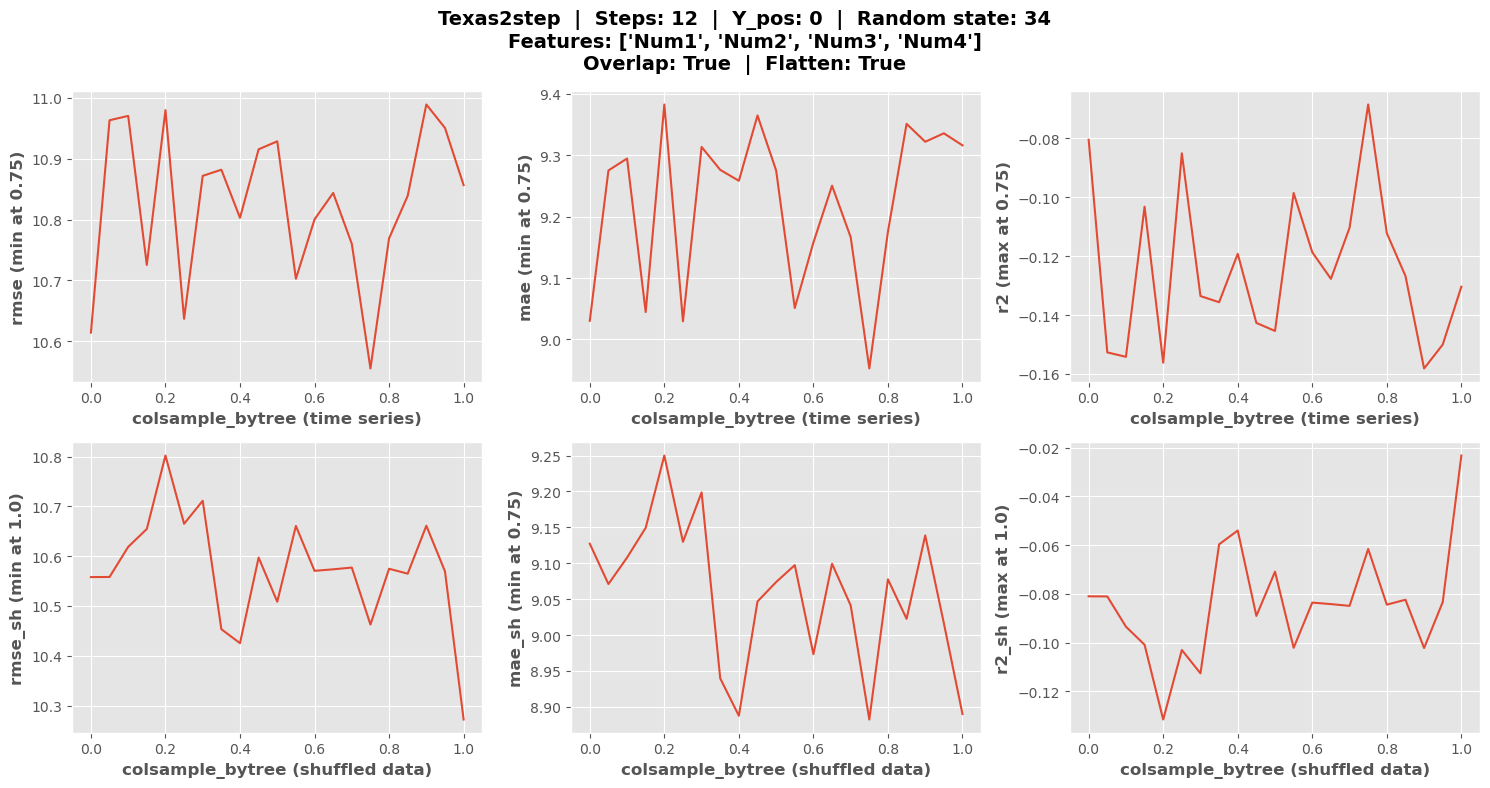

In [229]:
def plot_new(ax, a, b, xlabel, ylabel):
    ax.plot(a, b)
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_ylabel(ylabel, fontweight='bold')
        
    
plt.rcParams.update({'figure.figsize':(15,8)})    
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
axes = [0, ax1, ax2, ax3, ax4, ax5, ax6]
for idx in range(1,7):
    a = [i[0] for i in res] 
    b = [i[idx] for i in res]
    mode = 'shuffled data' if '_sh' in keys[idx] else 'time series'
    xlabel = f'{value_name} ({mode})'
        
    if not 'r2' in keys[idx]:
        min_b   = min(b)
        min_idx = b.index(min_b)        
        ylabel  = f'{keys[idx]} (min at {a[min_idx]})'
    else:
        max_b   = max(b)
        max_idx = b.index(max_b)
        ylabel  = f'{keys[idx]} (max at {a[max_idx]})'
        
    plot_new(axes[idx], a, b, xlabel, ylabel)

suptitle = f'{event.capitalize()}  |  Steps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}\n'
suptitle += f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}'
plt.suptitle(suptitle, fontsize=14, fontweight='bold')
plt.tight_layout()

# Part 3. Other Regressors
Best OOTB results -

In [14]:
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
#from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor

In [ ]:
clf_params = {
}

In [15]:
# FIT & TEST
regr = Lasso()
regr.fit( X_train, y_train )
y_pred = regr.predict( X_test )

# PRINT RESULTS
print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
print(f'Event: {event}\nTrain-test split: time series\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}\n')

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f'RMSE = {round(rmse, 4)}')
print(f'MAE  = {round(mae, 4)}')
print(f'R2   = {round(r2, 4)}')
print('\n', '+'*100, '\n', sep='')


# FIT & TEST
regr_sh = Lasso()
regr_sh.fit( X_train_sh, y_train_sh )
y_pred_sh = regr_sh.predict( X_test_sh )

# PRINT RESULTS
print( strftime("%Y-%m-%d %H:%M:%S", localtime()) )
print(f'Event: {event}\nTrain-test split: stratified w/shuffling\nSteps: {n_steps}  |  Y_pos: {y_pos}  |  Random state: {random_state}')
print(f'Features: {features}\nOverlap: {overlap}  |  Flatten: {flatten}\n')

rmse_sh = math.sqrt(mean_squared_error(y_test_sh, y_pred_sh))
mae_sh  = mean_absolute_error(y_test_sh, y_pred_sh)
r2_sh   = r2_score(y_test_sh, y_pred_sh)

print(f'RMSE = {round(rmse_sh, 4)}')
print(f'MAE  = {round(mae_sh, 4)}')
print(f'R2   = {round(r2_sh, 4)}')

2022-12-30 01:22:36
Event: tex2step
Train-test split: time series
Steps: 1  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2429
MAE  = 8.8406
R2   = -0.0047

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-12-30 01:22:36
Event: tex2step
Train-test split: stratified w/shuffling
Steps: 1  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.4462
MAE  = 9.1578
R2   = -0.01


In [258]:
regr_BAYESIAN = '''
2022-08-16 10:56:26
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2383
MAE  = 8.8367
R2   = -0.0053

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:56:26
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.1553
MAE  = 8.8255
R2   = -0.0001
'''

regr_LASSO = '''
2022-08-16 10:58:45
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2563
MAE  = 8.8476
R2   = -0.0088

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:58:45
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.195
MAE  = 8.8492
R2   = -0.0079
'''


res_SVR = '''
2022-08-16 10:41:33
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2713
MAE  = 8.8561
R2   = -0.0118

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:41:33
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2178
MAE  = 8.8648
R2   = -0.0125
'''

regr_RF = '''
2022-08-16 10:43:20
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2873
MAE  = 8.8743
R2   = -0.0149

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:43:22
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.3027
MAE  = 8.915
R2   = -0.0293
'''


regr_GRAD_BOOSTING = '''
2022-08-16 10:45:06
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.3963
MAE  = 8.937
R2   = -0.0366

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:45:07
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.1612
MAE  = 8.7571
R2   = -0.0013
'''


regr_CATBOOST = '''
2022-08-16 10:48:20
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.3757
MAE  = 8.8243
R2   = -0.0325

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:48:21
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.3928
MAE  = 8.9321
R2   = -0.0474
'''


regr_RIDGE = '''
2022-08-16 10:50:22
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.3279
MAE  = 8.9369
R2   = -0.023

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:50:22
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2727
MAE  = 8.8868
R2   = -0.0234
'''

res_LINEAR = '''
2022-08-16 10:42:21
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2912
MAE  = 8.8701
R2   = -0.0157

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:42:21
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2415
MAE  = 8.8619
R2   = -0.0172
'''


regr_KNN = '''
2022-08-16 10:47:19
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 11.2155
MAE  = 9.4786
R2   = -0.2063

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:47:19
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 11.2535
MAE  = 9.5769
R2   = -0.2281
'''

regr_ELASTIC = '''
2022-08-16 10:55:24
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2697
MAE  = 8.8563
R2   = -0.0115

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:55:24
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2136
MAE  = 8.8536
R2   = -0.0116
'''

regr_SGD = '''
2022-08-16 10:51:51
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 4332760933478.231
MAE  = 3545865220152.2407
R2   = -1.8003895659802453e+23

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:51:51
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 2608910470827.9346
MAE  = 2093144296986.7693
R2   = -6.600520609475939e+22
'''

In [260]:
print(res_svr)


2022-08-16 10:25:24
Event: texas2step
Train-test split: time series
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2713
MAE  = 8.8561
R2   = -0.0118

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

2022-08-16 10:25:25
Event: texas2step
Train-test split: stratified w/shuffling
Steps: 12  |  Y_pos: 0  |  Random state: 34
Features: ['Num1', 'Num2', 'Num3', 'Num4']
Overlap: True  |  Flatten: True

RMSE = 10.2178
MAE  = 8.8648
R2   = -0.0125



5

## Appendix

__BEST HPs__ based on HP search, but the predictions are sort limited to the centerline w/occasional variations

```python
n_steps = 12

regr_params_xgb = {
    'n_estimators': 100,
    'max_depth': None,                                # default 6
    'learning_rate': 0.2,                             # eta, default 0.3
    'objective': 'reg:squarederror',                  # reg:squarederror, reg:squaredlogerror, reg:pseudohubererror, reg:tweedie, reg:gamma           
    'eval_metric': 'rmse',                            # 'rmse', 'rmsle', 'mae', 'mape', 'mphe' (huber), 'logloss',
                                                      # OR 'eval_metric': mean_absolute_error, import sklearn metric, then reg.fit(X, y, eval_set=[(X, y)])
    #'early_stopping_rounds': 5,                      # requires eval_set
    'max_leaves': 0,                                  # max # leaves; default 0 - no limit
    'grow_policy': 'depthwise',                       # default 'depthwise', 'lossguide'
    'process_type': 'default',                        # 'default', 'update' for boosting
    'num_parallel_tree': 1,                           # default 1, num parallel trees built in each iteration
    'base_score': 0.5,
    'booster': 'gbtree',                              # gbtree, dart, gblinear?
    'tree_method': 'auto',                            # auto, exact, approx, hist and gpu_hist
    'importance_type': 'weight',                      # default“gain”,“weight”,“cover”,“total_gain”,“total_cover”
    'gamma': 0.4,                                     # larger - more conservative, [0, inf], default 0
    'reg_alpha': 0.9,                                 # L1 reg., larger - more conservative, default 0 (0.1)
    'reg_lambda': 8,                                  # L2 rreg., larger - more conservative, default 1 (0.3)
    'sampling_method': 'uniform',                     # uniform, gradient_based
    'max_delta_step': 0,                              # 1-10 or 0 for no constraint
    'min_child_weight': 1,
    'subsample': 0.7,                                 # 0-1  (lower values prevent overfitting), default 1
    'colsample_bylevel': 0,                           # 0-1, default 1
    'colsample_bynode': 1,                            # optimized for higher recall, default 1
    'colsample_bytree': 1,                            # 0-1, default 1
    'seed': 5,
    'random_state': random_state,
    'n_jobs': -1,
    #'callbacks':,    # e.g. xgboost.callback.EarlyStopping
}


X_train, X_test, y_train, y_test = train_test_split( X_sh, y_sh,
                                                     test_size=0.2,
                                                     random_state=random_state,
                                                     shuffle=True,
                                                     stratify=y, )

```